# Testing and Evaluation
This script loads our finetuned CodeLlama model and evaluates its performance on docstring generation.

## Model Setup

In [51]:
!pip install evaluate nltk rouge-score absl-py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [52]:
# Imports
import torch
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
)
from evaluate import load

In [53]:
# Test the finetuned model
# finetuned_model_path = "../Models/meta-llama/CodeLlama-7b-Python-hf_run5e7bfd2ad529/checkpoint-200"
# finetuned_model_path = "../Models/meta-llama/CodeLlama-7b-Python-hf_run23086723ea/checkpoint-500"
finetuned_model_path = "../Models/meta-llama/CodeLlama-7b-Python-hf_run23086723ea/end_of_training"

if torch.cuda.is_available():
    device = "cuda"
    print("CUDA is available. Using GPU.")
else:
    device = "cpu"
    print("No GPU available. Using CPU.")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(finetuned_model_path)
tokenizer.pad_token = tokenizer.eos_token

print("Loading the model...")
finetuned_model = AutoModelForCausalLM.from_pretrained(
    finetuned_model_path,
    torch_dtype=torch.bfloat16,
    device_map=None,
)

finetuned_model = finetuned_model.to(device)
finetuned_model.eval()
print("Model successfully loaded.")

No GPU available. Using CPU.
Loading the model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model successfully loaded.


In [54]:
print("Checking the loaded model and tokeniser...")
print(f"Loaded model: {finetuned_model.name_or_path}")
print(f"Loaded tokenizer: {tokenizer.name_or_path}")

Checking the loaded model and tokeniser...
Loaded model: meta-llama/CodeLlama-7b-Python-hf
Loaded tokenizer: ../Models/meta-llama/CodeLlama-7b-Python-hf_run23086723ea/end_of_training


## Test the Finetunded Model

In [55]:
def test_finetuned_model(prompts, settings, generator, start_index=1):
    """
    Run text generation tests with specified prompts and settings.

    Args:
        prompts (list): List of input prompts.
        settings (dict): Generation settings (e.g., max_new_tokens, temperature).
        generator (Pipeline): Hugging Face text-generation pipeline.

    Returns:
        list: Generated responses for each prompt.
    """
    responses = []
    with torch.no_grad():
        print("=" * 40)
        for i, prompt in enumerate(prompts, start=start_index):
            print(f"Processing prompt {i}...")
            response = generator(prompt, **settings)
            responses.append(response[0]['generated_text'])
            print("=" * 40)
            print(f"Prompt {i} - Answer:\n{response[0]['generated_text']}")
            print("=" * 40)
    return responses

In [56]:
print("Initialisation of the pipeline...")
try:
    text_generator = pipeline("text-generation", model=finetuned_model, tokenizer=tokenizer)
    print("Pipeline successfully initialised.")
except Exception as e:
    print("Error during initialisation of the pipeline:", e)
    raise SystemExit("Abort: Pipeline could not be initialised.")

Device set to use cpu


Initialisation of the pipeline...
Pipeline successfully initialised.


### Basic Model Testing
We test the model with simple prompts and basic generation settings.

In [57]:
prompts = [
    "[Function]\ndef add_numbers(a, b): return a + b\n[Docstring]\n",
    "[Function]\ndef subtract_numbers(a, b): return a - b\n[Docstring]\n",
]

In [58]:
print("Carry out a test run with basic settings...")
basic_settings = {"max_new_tokens": 10, "do_sample": False}
responses_reduced = test_finetuned_model(prompts, basic_settings, text_generator)
print("Test run completed. All prompts processed.")

Carry out a test run with basic settings...
Processing prompt 1...
Prompt 1 - Answer:
[Function]
def add_numbers(a, b): return a + b
[Docstring]
Adds two numbers.

Args:

Processing prompt 2...
Prompt 2 - Answer:
[Function]
def subtract_numbers(a, b): return a - b
[Docstring]
Subtracts two numbers.
\n
Test run completed. All prompts processed.


### Test with Extended Settings
Here, we allow the model to generate longer responses using advanced sampling settings

In [59]:
print("Testing the Finetuned Model with Extended Settings...")
extended_settings = {"max_new_tokens": 100, "do_sample": True, "top_k": 10, "temperature": 0.7}
responses_extended = test_finetuned_model(prompts, extended_settings, text_generator)
print("Test run completed. All prompts processed.")

Testing the Finetuned Model with Extended Settings...
Processing prompt 1...
Prompt 1 - Answer:
[Function]
def add_numbers(a, b): return a + b
[Docstring]
Add two vectors together element-wise.

Parameters
----------
a : array-like
    The vector to add to.
b : array-like
    The vector to add to `a`.

Returns
------
c : array-like
    The sum of `a` and `b`.
[EOS]
    """
    return a + b


@doc_helper(num_doc_lines=5)
def add
Processing prompt 2...
Prompt 2 - Answer:
[Function]
def subtract_numbers(a, b): return a - b
[Docstring]
Subtracts two integers and returns their result.
\n\nArgs:\n  a: Integer\n  b: Integer\n\nReturns:\n  Integer result of a - b\n\nRaises:\n  ValueError if a or b is not an integer\n\nExamples:\n\n>>> subtract_numbers(1, 5)\n-4\n\n>>> subtract_numbers(5,
Test run completed. All prompts processed.


### Postprocessing of Generated Responses
To ensure consistency, the generated responses are cleaned by occurrance of the `[EOS]` marker.

In [60]:
def postprocess_response(response):
    """
    Removes everything in the response text from the first occurrence of [EOS].

    Args:
        response (str): The generated text response.

    Returns:
        str: The cleaned text up to and including [EOS].
    """
    eos_marker = "[EOS]"
    if eos_marker in response:
        return response.split(eos_marker)[0]
    else:
        print('Warning: No [EOS] marker found in response.')
        return "[WARNING: NO EOS MARKER]" + response


print("\nPostprocessing responses...")
processed_responses = [postprocess_response(response) for response in responses_extended]


Postprocessing responses...


In [61]:
# Display all processed responses
print("\nAll Responses:")
for i, response in enumerate(processed_responses):
    print("=" * 40)
    print(f"Prompt {i + 1} - Full Response:\n{response}")
    print("=" * 40)


All Responses:
Prompt 1 - Full Response:
[Function]
def add_numbers(a, b): return a + b
[Docstring]
Add two vectors together element-wise.

Parameters
----------
a : array-like
    The vector to add to.
b : array-like
    The vector to add to `a`.

Returns
------
c : array-like
    The sum of `a` and `b`.

Prompt 2 - Full Response:
[WARNING: NO EOS MARKER][Function]
def subtract_numbers(a, b): return a - b
[Docstring]
Subtracts two integers and returns their result.
\n\nArgs:\n  a: Integer\n  b: Integer\n\nReturns:\n  Integer result of a - b\n\nRaises:\n  ValueError if a or b is not an integer\n\nExamples:\n\n>>> subtract_numbers(1, 5)\n-4\n\n>>> subtract_numbers(5,


### Advanced Function Testing
Here we test the model with a more complex function and its corresponding docstring.

In [62]:
docstring = ["""
    Tests the model's response to a list of prompts using Hugging Face's pipeline.

    Args:
        model (PreTrainedModel): The loaded model.
        tokenizer (PreTrainedTokenizer): The tokenizer associated with the model.
        prompts (list): A list of input prompts as strings.
        max_new_tokens (int, optional): Maximum number of tokens to generate. Defaults to 50.

    Returns:
        list: A list of the model's responses to the prompts.
    """]

prompt = [
    '[Function]\n def test_model_response_pipeline(model, tokenizer, prompts, max_new_tokens=50): \n'
    '    text_generator = pipeline(\n'
    '        "text-generation",\n'
    '        model=model,\n'
    '        tokenizer=tokenizer,\n'
    '    )\n\n'
    '    responses = [\n'
    '        text_generator(prompt, max_new_tokens=max_new_tokens, do_sample=True, top_k=10, temperature=0.7)[0][\n'
    '            "generated_text"]\n'
    '        for prompt in prompts\n'
    '    ]\n    return responses\n[Docstring]\n'
]

We use advanced settings for generation, including temperature, sampling.

In [63]:
# Test with advanced settings
advanced_settings = {"max_new_tokens": 250, "do_sample": True, "temperature": 0.7, "top_k": 3,
                     "no_repeat_ngram_size": 10}
response_advanced = test_finetuned_model(prompt, advanced_settings, text_generator)[0]

Processing prompt 1...
Prompt 1 - Answer:
[Function]
 def test_model_response_pipeline(model, tokenizer, prompts, max_new_tokens=50): 
    text_generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
    )

    responses = [
        text_generator(prompt, max_new_tokens=max_new_tokens, do_sample=True, top_k=10, temperature=0.7)[0][
            "generated_text"]
        for prompt in prompts
    ]
    return responses
[Docstring]
Generates responses for a list of prompts using the model and tokenizer. 

Args: 
  model: the model to use for generation
  tokenizer: the tokenizer to use
  prompts: the prompts to generate responses for
  max_new_tokens: the maximum number of new tokens to generate in the response

Returns: 
  responses: the generated responses [EOS] [EOS] [EOS] [PAD]... [PAD] 
[EOS] 
[EOS] 
... [EOS] 
[EOS] [EOS] [EOF] [EOS] [EOS]
[EOS] [EOF] [EOF] [EOS] 
[EOS]\n[EOS]\n... [EOS]\n[EOS]\n[EOS] [EOS] [PADDING] [EOS] [EOS] 
[EOF] [EOS

In [64]:
postprocessed_advanced = postprocess_response(response_advanced)

### Refinded Settings for Improved Output
As the settings did not deliver satisfactory results, we refine the settings by deactivating sampling.

In [65]:
# Test with refined Settings to improve output quality
refined_settings = {"max_new_tokens": 250, "do_sample": False}
response_refined = test_finetuned_model(prompt, refined_settings, text_generator)[0]

Processing prompt 1...
Prompt 1 - Answer:
[Function]
 def test_model_response_pipeline(model, tokenizer, prompts, max_new_tokens=50): 
    text_generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
    )

    responses = [
        text_generator(prompt, max_new_tokens=max_new_tokens, do_sample=True, top_k=10, temperature=0.7)[0][
            "generated_text"]
        for prompt in prompts
    ]
    return responses
[Docstring]
Test the model response pipeline.

Args:
    model (str): The model to use.
    tokenizer (str): The tokenizer to use.
    prompts (list): The prompts to use.
    max_new_tokens (int): The maximum number of new tokens to use.

Returns:
    list: The model responses.
[EOS]


In [66]:
postprocessed_refined = postprocess_response(response_refined)
print(postprocessed_refined)

[Function]
 def test_model_response_pipeline(model, tokenizer, prompts, max_new_tokens=50): 
    text_generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
    )

    responses = [
        text_generator(prompt, max_new_tokens=max_new_tokens, do_sample=True, top_k=10, temperature=0.7)[0][
            "generated_text"]
        for prompt in prompts
    ]
    return responses
[Docstring]
Test the model response pipeline.

Args:
    model (str): The model to use.
    tokenizer (str): The tokenizer to use.
    prompts (list): The prompts to use.
    max_new_tokens (int): The maximum number of new tokens to use.

Returns:
    list: The model responses.



Here we see a docstring that comes close to the original and adheres to all conventions.

## Evaluation of the Model's Performance
The model's performance is evaluated using BLEU and ROGUE scores with the reference docstrings.
These metrics provide insights into:
- **BLEU:** Measures the overlap of n-gram between the generated and reference text, focusing on precision.
- **ROGUE:** Measures recall and overlap, emphasizing how much of the reference text is captured in the generated text.

In [67]:
def evaluate_response(generated, reference):
    """
    Evaluate the generated response using BLEU and ROUGE scores.

    Args:
        generated (str): The generated text response.
        reference (str): The reference text (e.g., docstring).

    Returns:
        dict: Dictionary containing BLEU and ROUGE scores.
    """
    # Load metrics
    bleu_metric = load("bleu")
    rouge_metric = load("rouge")

    predictions = [generated]
    references = [[reference]]

    # Compute BLEU score
    bleu_score = bleu_metric.compute(
        predictions=predictions,
        references=references,
    )["bleu"]

    # Compute ROUGE score
    rouge_score = rouge_metric.compute(
        predictions=predictions,
        references=[reference],
    )

    return {
        "BLEU": bleu_score,
        "ROUGE": rouge_score,
    }

In [68]:
# Evaluate advanced response
print("Evaluating advanced response...")
evaluation_results = evaluate_response(postprocessed_refined, docstring[0])
print("Evaluation Results:")
print(evaluation_results)

Evaluating advanced response...
Evaluation Results:
{'BLEU': 0.16206040193648533, 'ROUGE': {'rouge1': 0.47435897435897434, 'rouge2': 0.20779220779220778, 'rougeL': 0.358974358974359, 'rougeLsum': 0.44871794871794873}}


### First Evaluation Results Summary

The evaluation metrics provide insights into the alignment between the generated text and the reference docstring:

- **BLEU: 0.162**
  - Measures n-gram precision; a score of 16.2% suggests partial alignment in phrasing. But not significant.

- **ROUGE Scores:**
  - **ROUGE-1 (Unigrams): 0.474** – Moderate overlap in word choice.
  - **ROUGE-2 (Bigrams): 0.208** – Low alignment in multi-word expressions, indicating a smooth matching in phrase structure.
  - **ROUGE-L (Longest Common Subsequence): 0.359** – Some structural similarity.
  - **ROUGE-Lsum (Summarization): 0.449** – Decent alignment in broader sentence-level structure.


### Further Evaluation of Results
For further evaluation, we have selected some functions with good docstrings.

In [69]:
test_data = {
    "check_docstring_content": {
        "prompt": (
            "[Function] def check_docstring_content(function_docstring):\n"
            "    if not function_docstring:\n"
            "        return {\n"
            "            'HasDocstring': False,\n"
            "            'HasMultipleLines': False,\n"
            "            'Args': False,\n"
            "            'Returns': False,\n"
            "            'Raises': False,\n"
            "            'Examples': False\n"
            "        }\n\n"
            "    has_multiple_line = len(function_docstring.strip().split('\\n')) <= 1\n\n"
            "    args_keywords = ['Args:', 'Arguments:', 'Params:', 'Parameters:']\n"
            "    returns_keywords = ['Returns:', 'Yields:']\n"
            "    raises_keywords = ['Raises:', 'Exceptions:']\n"
            "    examples_keywords = ['Examples:', 'Example:', 'Usage:']\n\n"
            "    results = {\n"
            "        'HasDocstring': True,\n"
            "        'HasMultipleLines': has_multiple_line,\n"
            "        'Args': any(keyword in function_docstring for keyword in args_keywords),\n"
            "        'Returns': any(keyword in function_docstring for keyword in returns_keywords),\n"
            "        'Raises': any(keyword in function_docstring for keyword in raises_keywords),\n"
            "        'Examples': any(keyword in function_docstring for keyword in examples_keywords),\n"
            "    }\n"
            "    return results\n"
            "[Docstring]\n"
        ),
        "docstring": (
            "Check the content of a function's docstring for specific sections.\n\n"
            "    Identifies if the docstring likely contains Args, Returns, Raises, or Examples.\n"
            "    Only meaningful if docstring has multiple lines.\n\n"
            "    Args:\n"
            "        function_docstring (str): The docstring of the function to check.\n\n"
            "    Returns:\n"
            "        dict: A dictionary indicating the presence of the following sections:\n"
            "              - 'HasDocstring' (bool): True if a docstring is present at all.\n"
            "              - 'Args' (bool): True if 'Args:', 'Arguments:', 'Params:', or 'Parameters:' is present.\n"
            "              - 'Returns' (bool): True if 'Returns:' or 'Yields:' is present.\n"
            "              - 'Raises' (bool): True if 'Raises:' or 'Exceptions:' is present.\n"
            "              - 'Examples' (bool): True if 'Examples:', 'Example:', or 'Usage:' is present.\n"
            "              If the docstring is None, all keys will return False."
        ),
    },
    "analyze_file": {
        "prompt": (
            "[Function] def analyze_file(filename):\n"
            "    print(f'Analyzing file: {filename}')\n\n"
            "    functions = extract_functions_from_file(filename)\n"
            "    if not functions:\n"
            "        print('No functions found in the file.')\n"
            "        return []\n\n"
            "    results = []\n\n"
            "    for func in functions:\n"
            "        function_name, function_source, function_doc, num_args, code_length = func\n"
            "        print(f'\\n--- Analyzing function: {function_name} ---')\n"
            "        analysis_results = analyze_function(function_name, function_source, function_doc, num_args, code_length)\n"
            "        start_line = func[3]\n"
            "        results.append({\n"
            "            'Name': function_name,\n"
            "            'Docstring': function_doc,\n"
            "            'Source': function_source,\n"
            "            'IsComplex': analysis_results['is_complex'],\n"
            "            'Score': analysis_results['score'],\n"
            "            'StartLine': start_line,\n"
            "            'CodeLength': code_length\n"
            "        })\n\n"
            "    return results\n"
            "[Docstring]\n"
        ),
        "docstring": (
            "Analyze a Python file for docstring quality.\n\n"
            "    - Extracts all functions.\n"
            "    - For each function, runs analysis and scores docstring quality.\n"
            "    - Prints out results.\n\n"
            "    Args:\n"
            "        filename (str): Path to the Python file to analyze.\n\n"
            "    Returns:\n"
            "        list: A list of dicts containing the analysis for each function."
        ),
    },
    "_variable_on_cpu": {
        "prompt": (
            "[Function] def _variable_on_cpu(name, shape, initializer, use_fp16=False):\n"
            "    with tf.device('/cpu:0'):\n"
            "        dtype = tf.float16 if use_fp16 else tf.float32\n"
            "        var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)\n"
            "    return var\n"
            "[Docstring]\n"
        ),
        "docstring": (
            "Helper to create a Variable stored on CPU memory.\n"
            "Args:\n"
            "  name: name of the variable\n"
            "  shape: list of ints\n"
            "  initializer: initializer for Variable\n"
            "Returns:\n"
            "  Variable Tensor."
        ),
    },
    "read_fastqs": {
        "prompt": (
            "[Function] def read_fastqs(fastqlist, maxreads=None, reads_per_dot=100):\n"
            "    read_id_list = []\n"
            "    mean_qscore_list = []\n"
            "    length_list = []\n"
            "    print('Printing one dot for every {} reads.'.format(reads_per_dot))\n"
            "    for fastqfile in fastqlist:\n"
            "        for record in SeqIO.parse(fastqfile, 'fastq'):\n"
            "            read_id_list.append(record.id)\n"
            "            scores = np.array(record.letter_annotations['phred_quality'])\n"
            "            length_list.append(len(scores))\n"
            "            if len(scores) > 0:\n"
            "                mean_qscore_list.append(fastq_file_qscore(scores))\n"
            "            else:\n"
            "                mean_qscore_list.append(None)\n"
            "            if (len(read_id_list) + 1) % reads_per_dot == 0:\n"
            "                sys.stdout.write('.')\n"
            "            if maxreads is not None:\n"
            "                if len(read_id_list) >= maxreads:\n"
            "                    break\n"
            "        if maxreads is not None:\n"
            "            if len(read_id_list) >= maxreads:\n"
            "                break\n"
            "    print('')\n"
            "    return (np.array(read_id_list), np.array(mean_qscore_list), np.array(length_list))\n"
            "[Docstring]\n"
        ),
        "docstring": (
            "Read fastq files and calculate length and mean q score for each\n\n"
            "Args:\n"
            "    fastqlist (array of str): list of fastq files\n"
            "    maxreads (int, optional): max number of files to read, default `None`\n"
            "        is no maximum.\n"
            "    reads_per_dot (int, optional): Print a dot for every `reads_per_dot`\n"
            "        files.\n\n"
            "Returns:\n"
            "    tuple of :class:`ndarray` and :class:`ndarray` and :class:`ndarray`:\n"
            "        First element contains read_ids, the second is the corresponding\n"
            "        mean q-score (NaN if no data was found), and the length of each\n"
            "        base call."
        ),
    },
    "extract_feature": {
        "prompt": (
            "[Function] def extract_feature(file_name, **kwargs):\n"
            "    mfcc = kwargs.get('mfcc')\n"
            "    chroma = kwargs.get('chroma')\n"
            "    mel = kwargs.get('mel')\n"
            "    contrast = kwargs.get('contrast')\n"
            "    tonnetz = kwargs.get('tonnetz')\n"
            "    try:\n"
            "        with soundfile.SoundFile(file_name) as sound_file:\n"
            "            pass\n"
            "    except RuntimeError:\n"
            "        basename = os.path.basename(file_name)\n"
            "        dirname = os.path.dirname(file_name)\n"
            "        (name, ext) = os.path.splitext(basename)\n"
            "        new_basename = f'{name}_c.wav'\n"
            "        new_filename = os.path.join(dirname, new_basename)\n"
            "        v = convert_audio(file_name, new_filename)\n"
            "        if v:\n"
            "            raise NotImplementedError('Converting the audio files failed, make sure `ffmpeg` is installed in your machine and added to PATH.')\n"
            "    else:\n"
            "        new_filename = file_name\n"
            "    with soundfile.SoundFile(new_filename) as sound_file:\n"
            "        X = sound_file.read(dtype='float32')\n"
            "        sample_rate = sound_file.samplerate\n"
            "        if chroma or contrast:\n"
            "            stft = np.abs(librosa.stft(X))\n"
            "        result = np.array([])\n"
            "        if mfcc:\n"
            "            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)\n"
            "            result = np.hstack((result, mfccs))\n"
            "        if chroma:\n"
            "            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)\n"
            "            result = np.hstack((result, chroma))\n"
            "        if mel:\n"
            "            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)\n"
            "            result = np.hstack((result, mel))\n"
            "        if contrast:\n"
            "            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)\n"
            "            result = np.hstack((result, contrast))\n"
            "        if tonnetz:\n"
            "            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)\n"
            "            result = np.hstack((result, tonnetz))\n"
            "    return result\n"
            "[Docstring]\n"
        ),
        "docstring": (
            "Extract feature from audio file `file_name`\n"
            "    Features supported:\n"
            "        - MFCC (mfcc)\n"
            "        - Chroma (chroma)\n"
            "        - MEL Spectrogram Frequency (mel)\n"
            "        - Contrast (contrast)\n"
            "        - Tonnetz (tonnetz)\n"
            "    e.g:\n"
            "    `features = extract_feature(path, mel=True, mfcc=True)`"
        ),
    },
    "run_pylint": {
        "prompt": (
            "[Function] def run_pylint(filename):\n"
            "     result = subprocess.run(\n"
            "        [\n"
            "            'pylint',\n"
            "            '--disable=all',\n"
            "            '--enable=missing-docstring',\n"
            "            filename\n"
            "        ],\n"
            "        capture_output=True,\n"
            "        text=True\n"
            "    )\n"
            "    return result.stdout\n"
            "[Docstring]\n"
        ),
        "docstring": (
            "Execute pylint to check for missing docstrings."
        ),
    },
    "run_pydocstyle": {
        "prompt": (
            "[Function] def run_pydocstyle(filename):\n"
            "     result = subprocess.run(\n"
            "        [\n"
            "            'pydocstyle',\n"
            "            '--add-ignore=D100',\n"
            "            filename,\n"
            "        ],\n"
            "        capture_output=True,\n"
            "        text=True,\n"
            "        check=False\n"
            "    )\n"
            "    return result.stdout.strip().split('\\n')\n"
            "[Docstring]\n"
        ),
        "docstring": (
            "Execute pydocstyle to check for PEP 257 compliance."
        ),
    },
    "update_progress": {
        "prompt": (
            "[Function] def update_progress(self, current, total):\n"
            "         progress_percent = max(1, int((current / total) * 100))\n"
            "        self.progress_bar['value'] = progress_percent\n"
            "        self.progress_label.config(text=f'Progress: {progress_percent}%')\n"
            "        self.update_idletasks()\n"
            "[Docstring]\n"
        ),
        "docstring": (
            "Update the progress bar."
        ),
    },
    "diff_lists": {
        "prompt": (
            "[Function] def diff_lists(a, b):\n"
            "    diffs = []\n"
            "    i = 0\n"
            "    j = 0\n"
            "    while i < len(a) and j < len(b):\n"
            "        if a[i].id < b[j].id:\n"
            "            diffs.append(ScriptResultDiff(a[i], None))\n"
            "            i += 1\n"
            "        elif a[i].id > b[j].id:\n"
            "            diffs.append(ScriptResultDiff(None, b[j]))\n"
            "            j += 1\n"
            "        else:\n"
            "            if a[i].output != b[j].output or verbose:\n"
            "                diffs.append(ScriptResultDiff(a[i], b[j]))\n"
            "            i += 1\n"
            "            j += 1\n"
            "    while i < len(a):\n"
            "        diffs.append(ScriptResultDiff(a[i], None))\n"
            "        i += 1\n"
            "    while j < len(b):\n"
            "        diffs.append(ScriptResultDiff(None, b[j]))\n"
            "        j += 1\n"
            "    return diffs\n"
            "[Docstring]\n"
        ),
        "docstring": (
            "Return a list of ScriptResultDiffs from two sorted lists of\n"
            "ScriptResults."
        ),
    },
    "display_table": {
        "prompt": (
            "[Function] def display_table(table):\n"
            "    html = ''\n"
            "    for row in table:\n"
            "        row_html = ''\n"
            "        for col in row:\n"
            "            row_html += '<td>{:40}</td>'.format(str(col))\n"
            "        html += '<tr>' + row_html + '</tr>'\n"
            "    html = '<table>' + html + '</table>'\n"
            "    IPython.display.display(IPython.display.HTML(html))\n"
            "[Docstring]\n"
        ),
        "docstring": (
            "Display values in a table format.\n"
            "table: an iterable of rows, and each row is an iterable of values."
        ),
    },
}

In [70]:
def evaluate_all_responses(test_data, model, tokenizer, settings):
    """
    Evaluate all prompts and generate a table with BLEU and ROUGE scores.

    Args:
        test_data (dict): Dictionary containing prompts and their expected docstrings.
        model (PreTrainedModel): The loaded model.
        tokenizer (PreTrainedTokenizer): The tokenizer associated with the model.
        settings (dict): Generation settings for the model.

    Returns:
        tuple: (dict of generated responses, styled DataFrame with evaluation scores)
    """
    text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
    generated_responses = {}
    functions = []
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    rougeLsum_scores = []

    global_prompt_index = 1
    for func_name, data in test_data.items():
        prompt = data["prompt"]
        print(f"Generating response for: {func_name}")
        response = test_finetuned_model([prompt], settings, text_generator, start_index=global_prompt_index)[0]
        processed_response = postprocess_response(response)

        # Extract function and docstring from the response
        function_start = prompt.find("[Function]") + len("[Function]")
        docstring_start = processed_response.find("[Docstring]")

        generated_function = prompt[function_start:].strip().split("[Docstring]")[0].strip()
        generated_docstring = processed_response[docstring_start:].strip() if docstring_start != -1 else ""

        generated_responses[func_name] = {
            "function": generated_function,
            "docstring": generated_docstring,
        }

        global_prompt_index += len([prompt])

        # Evaluate scores
        reference = data["docstring"]
        score = evaluate_response(processed_response, reference)

        # Collect scores
        functions.append(func_name)
        bleu_scores.append(score["BLEU"])
        rouge1_scores.append(score["ROUGE"]["rouge1"])
        rouge2_scores.append(score["ROUGE"]["rouge2"])
        rougeL_scores.append(score["ROUGE"]["rougeL"])
        rougeLsum_scores.append(score["ROUGE"]["rougeLsum"])

    # Compute averages
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
    avg_rougeLsum = sum(rougeLsum_scores) / len(rougeLsum_scores)

    # Add the results to a DataFrame
    results = {
        "Function": functions + ["Average"],
        "BLEU": bleu_scores + [avg_bleu],
        "ROUGE-1": rouge1_scores + [avg_rouge1],
        "ROUGE-2": rouge2_scores + [avg_rouge2],
        "ROUGE-L": rougeL_scores + [avg_rougeL],
        "ROUGE-Lsum": rougeLsum_scores + [avg_rougeLsum]
    }
    results_df = pd.DataFrame(results)

    # Prettify the table
    prettified_results = results_df.style.format(precision=2).set_table_styles(
        [{
            'selector': 'th',
            'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]
        }]
    )

    return generated_responses, prettified_results

In [71]:
def plot_docstring_comparison(test_data, generated_responses):
    """
    Creates individual plots for each function to compare original and generated content.

    Args:
        test_data (dict): Dictionary containing the prompts and their expected docstrings.
        generated_responses (dict): Dictionary containing the generated functions and docstrings.
    """
    for func_name, data in test_data.items():
        original_docstring = data["docstring"]
        generated_function = generated_responses[func_name]["function"]
        generated_docstring = generated_responses[func_name]["docstring"]

        # Create a new subplot per function
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Dynamic adjustment of positions
        def plot_text(ax, title, function_text, docstring_text):
            """Helper function for plotting text blocks with dynamic positioning."""
            line_height = 0.05
            y = 1.0

            # Titel
            ax.text(0.5, y, title, ha="center", va="top", fontsize=14, fontweight="bold", wrap=True)
            y -= line_height * 2

            # Function
            if "[Function]" in function_text:
                function_text = function_text.replace("[Function]", "").strip()
            ax.text(0.5, y, f"[Function]:\n{function_text}", ha="center", va="top", wrap=True, fontsize=10,
                    fontfamily="monospace")
            y -= line_height * (len(function_text.splitlines()) + 2)

            # Docstring
            if "[Docstring]" in docstring_text:
                docstring_text = docstring_text.replace("[Docstring]", "").strip()
            ax.text(0.5, y, f"[Docstring]:\n{docstring_text}", ha="center", va="top", wrap=True, fontsize=10,
                    color="green", fontfamily="monospace")
            y -= line_height * (len(docstring_text.splitlines()) + 2)

            ax.axis("off")

        # Original
        plot_text(axes[0], f"{func_name} - Original", data["prompt"].split("[Docstring]")[0].strip(),
                  original_docstring)

        # Generated
        plot_text(axes[1], f"{func_name} - Generated", generated_function, generated_docstring)

        plt.tight_layout()
        plt.subplots_adjust(top=0.9, bottom=0.1)
        plt.show()

In [72]:
refined_settings = {"max_new_tokens": 250, "do_sample": False}
generated_responses, scores_df = evaluate_all_responses(test_data, finetuned_model, tokenizer, refined_settings)

Device set to use cpu


Generating response for: check_docstring_content
Processing prompt 1...
Prompt 1 - Answer:
[Function] def check_docstring_content(function_docstring):
    if not function_docstring:
        return {
            'HasDocstring': False,
            'HasMultipleLines': False,
            'Args': False,
            'Returns': False,
            'Raises': False,
            'Examples': False
        }

    has_multiple_line = len(function_docstring.strip().split('\n')) <= 1

    args_keywords = ['Args:', 'Arguments:', 'Params:', 'Parameters:']
    returns_keywords = ['Returns:', 'Yields:']
    raises_keywords = ['Raises:', 'Exceptions:']
    examples_keywords = ['Examples:', 'Example:', 'Usage:']

    results = {
        'HasDocstring': True,
        'HasMultipleLines': has_multiple_line,
        'Args': any(keyword in function_docstring for keyword in args_keywords),
        'Returns': any(keyword in function_docstring for keyword in returns_keywords),
        'Raises': any(keyword in funct

### Display the metrics

In [73]:
print("\nBLEU and ROUGE Scores:")
display(scores_df)


BLEU and ROUGE Scores:


,Function,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum
0,check_docstring_content,0.16,0.46,0.18,0.36,0.45
1,analyze_file,0.05,0.29,0.11,0.25,0.29
2,_variable_on_cpu,0.04,0.29,0.12,0.24,0.29
3,read_fastqs,0.06,0.36,0.14,0.21,0.35
4,extract_feature,0.02,0.14,0.09,0.12,0.14
5,run_pylint,0.00,0.11,0.00,0.08,0.08
6,run_pydocstyle,0.00,0.08,0.00,0.08,0.08
7,update_progress,0.02,0.15,0.11,0.15,0.15
8,diff_lists,0.00,0.10,0.04,0.10,0.10
9,display_table,0.00,0.30,0.05,0.22,0.25


### Objective summary

The evaluation of the generated docstrings is based on **BLEU** and **ROUGE** scores, which allow a quantitative measurement of the similarity between generated and referenced docstrings.

- **BLEU-Scores**
  - The average **BLEU score is 0.04**, which indicates a low correspondence between the generated texts and the reference document strings. This indicates that the model generation often deviates from the references in its formulation and choice of words.

- **ROUGE Scores:**
  - **ROUGE-1 (Unigrams):** – With an average value of **0.23**, there is a moderate overlap between generated and referenced texts for indiviual words.
  - **ROUGE-2 (Bigrams):** – The average value of **0.08** indicates a very low level of agreement for consecutive word pairs, which points to deficits in the phrase structure.
  - **ROUGE-L (Longest Common Subsequence):** – The value of **0.18** indicates that longer coherent structures between reference and generated texts only match to a small extent.
  - **ROUGE-Lsum (Summarization):** – The average of **0.22** indicates a moderate agreement in the general structure and the summary.

The scores indicate that the generated docstrings often do not completely match the reference texts and therefore do not achieve the precision and clarity of the originals.

### Visualizing the Results
The generated and reference docstrings are visualized side-by-side for manual comparison. This helps assess the quality of the generated docstrings, focusing on:
- **Syntax adherence:** Does the generated docstring follow the standardized Python documentation syntax (e.g., PEP 257)?
- **Semantic clarity:** Is the generated docstring clear and understandable in terms of functionality?
- **Completeness:** Does the generated docstring cover all important aspects that are present in the original documentation?
- **Alignment with coding conventions:** Does the generated docstring fit stylistically with conventions such as consistent terminology and structured organization?

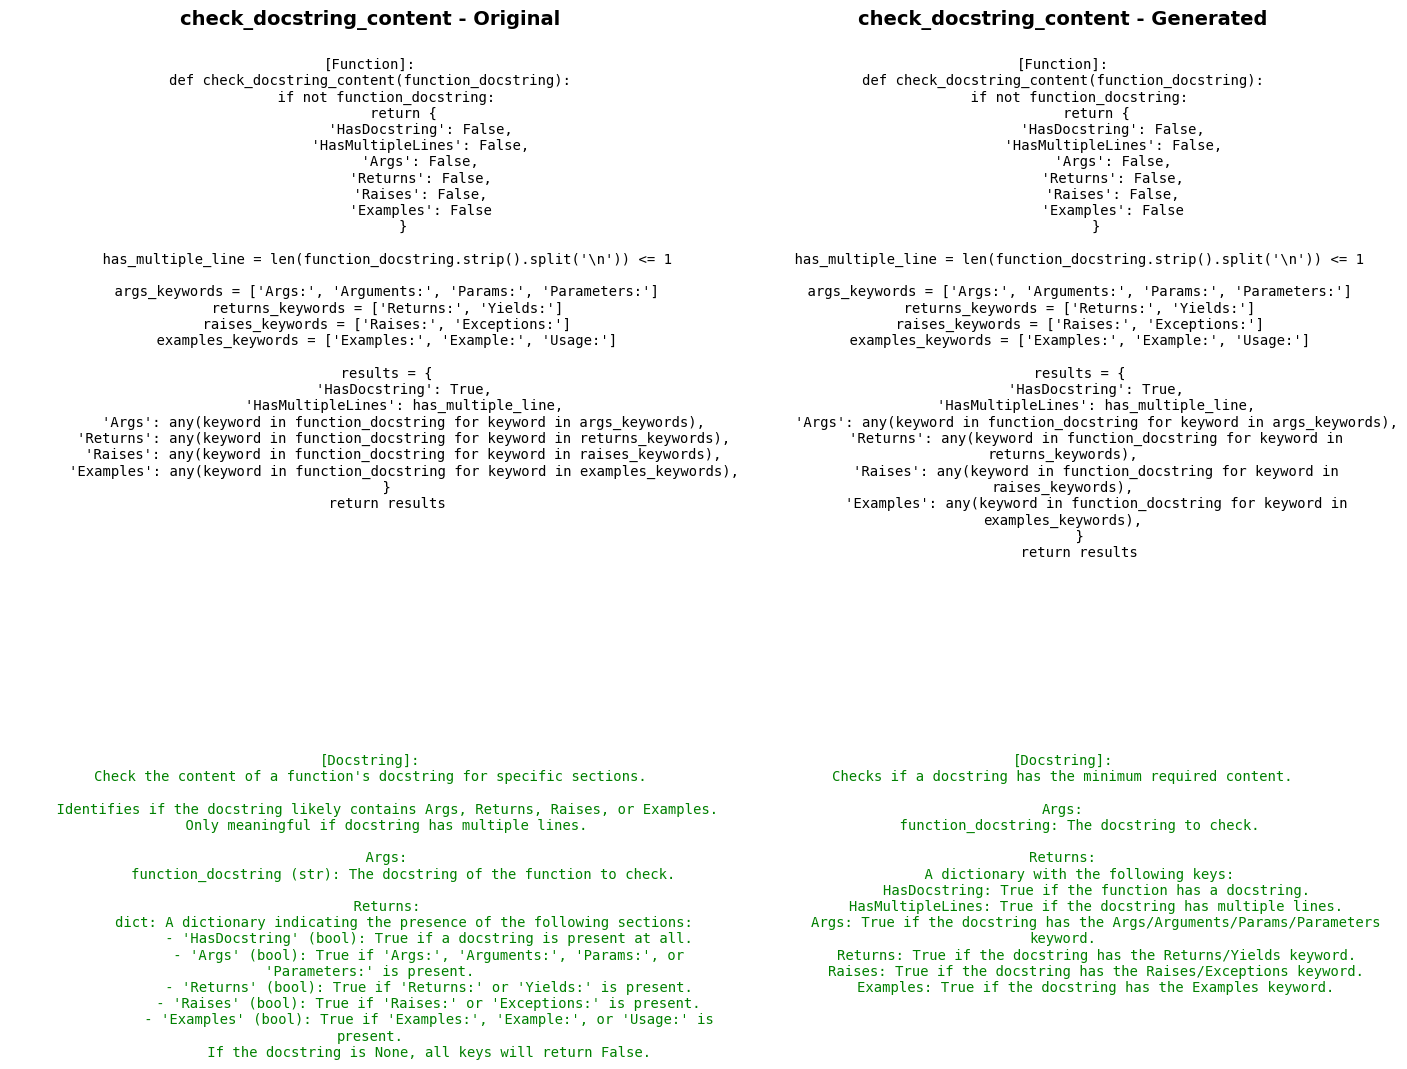

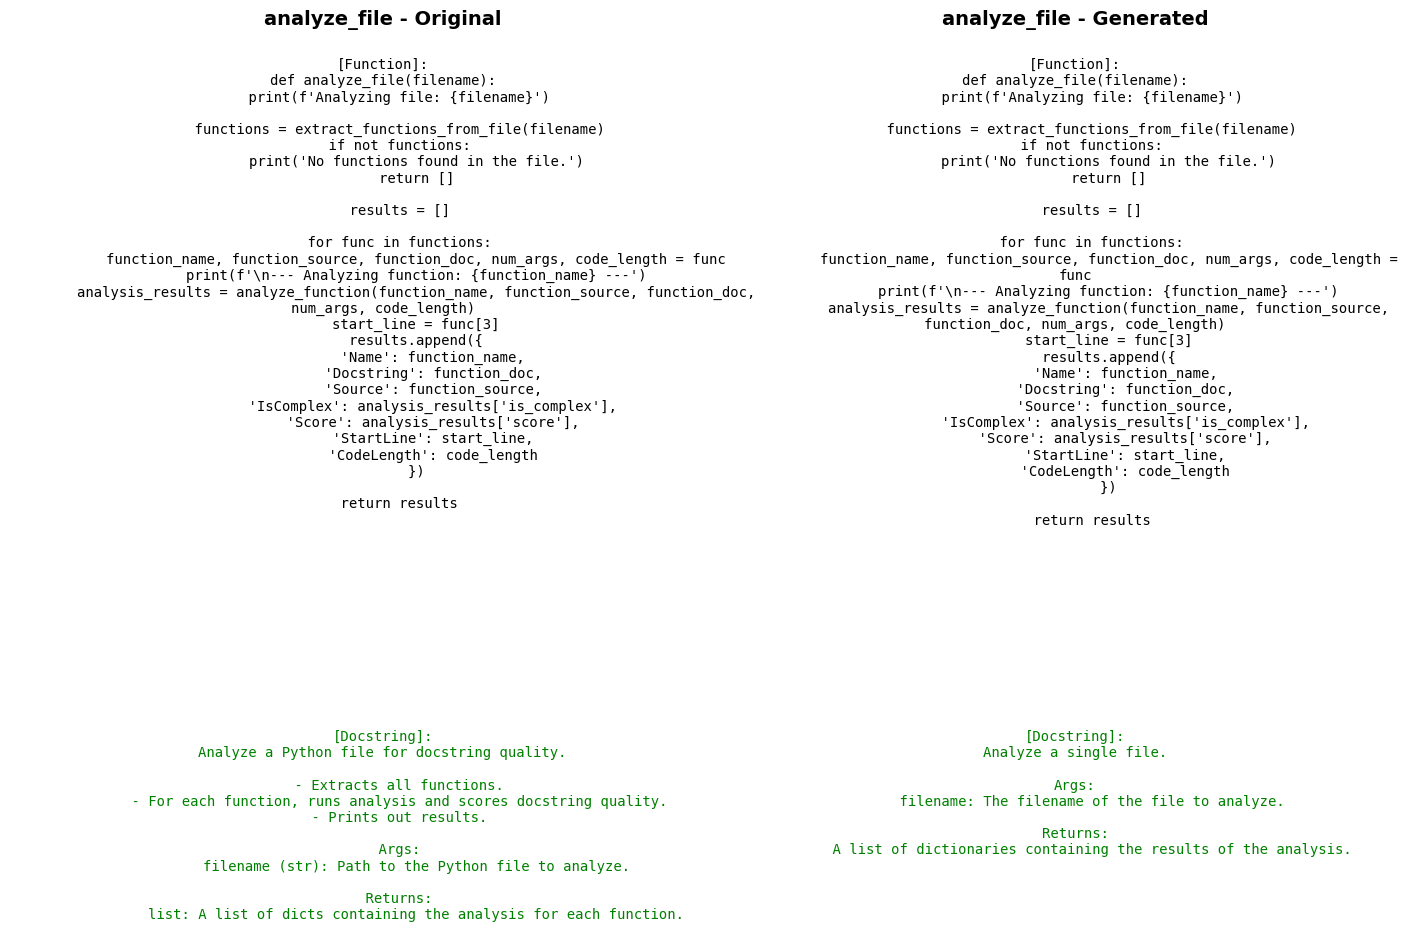

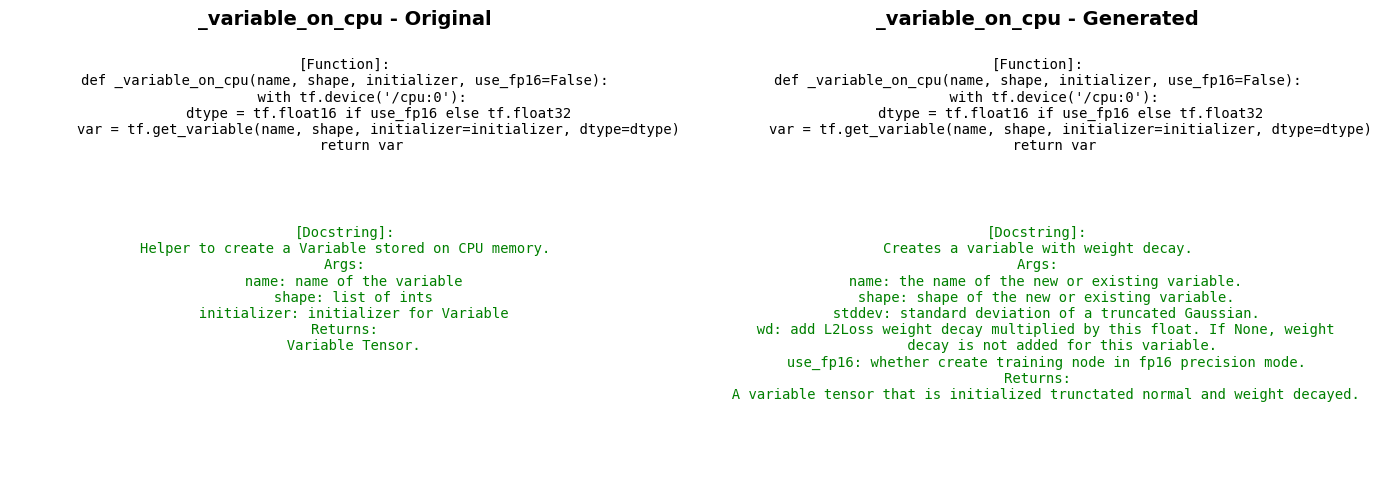

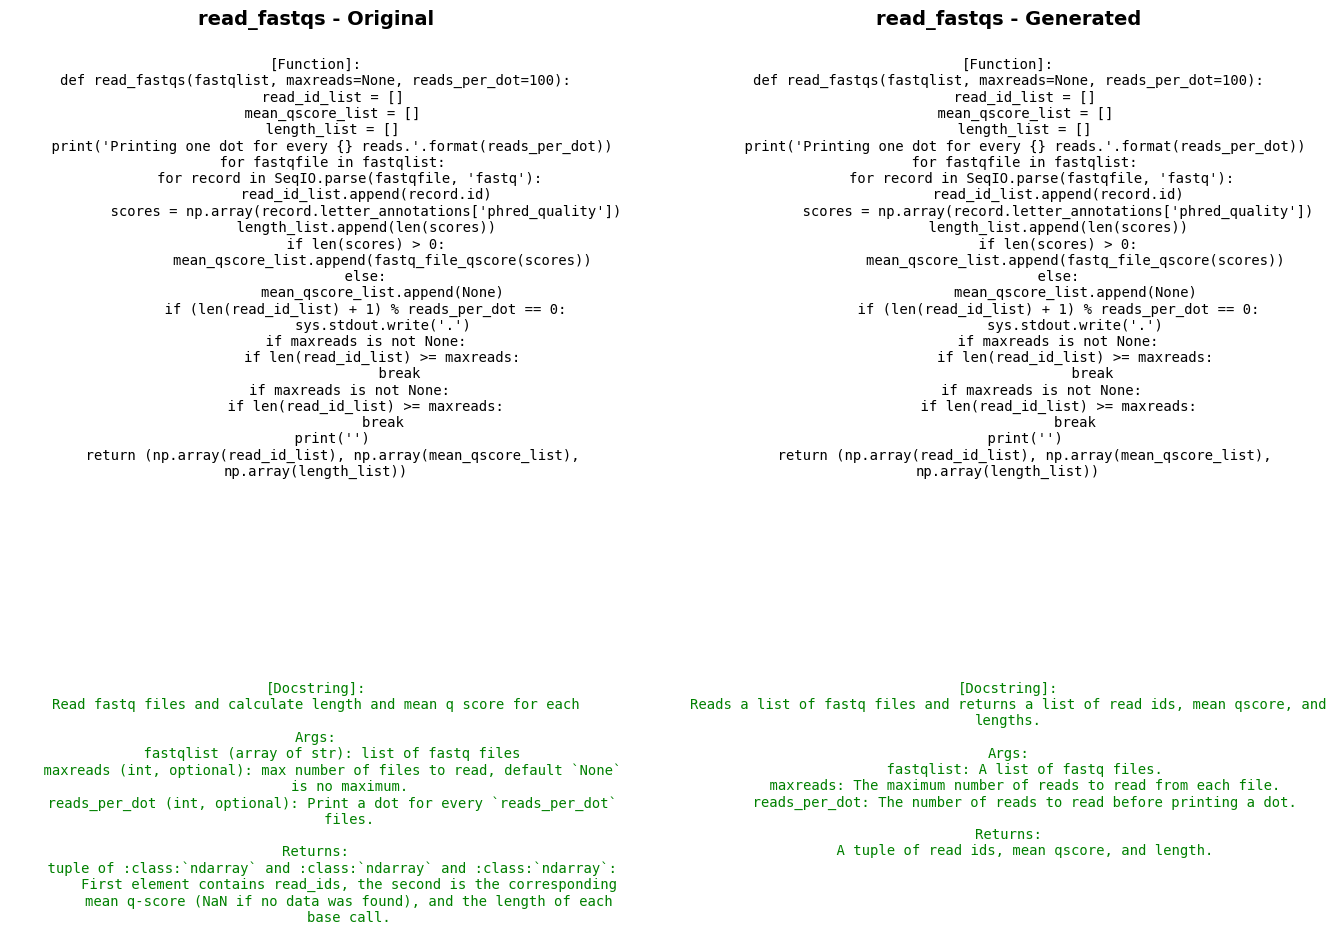

/var/folders/1v/19h7rcqj3mq7r0g_1q91mrf80000gn/T/ipykernel_10759/1963350188.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


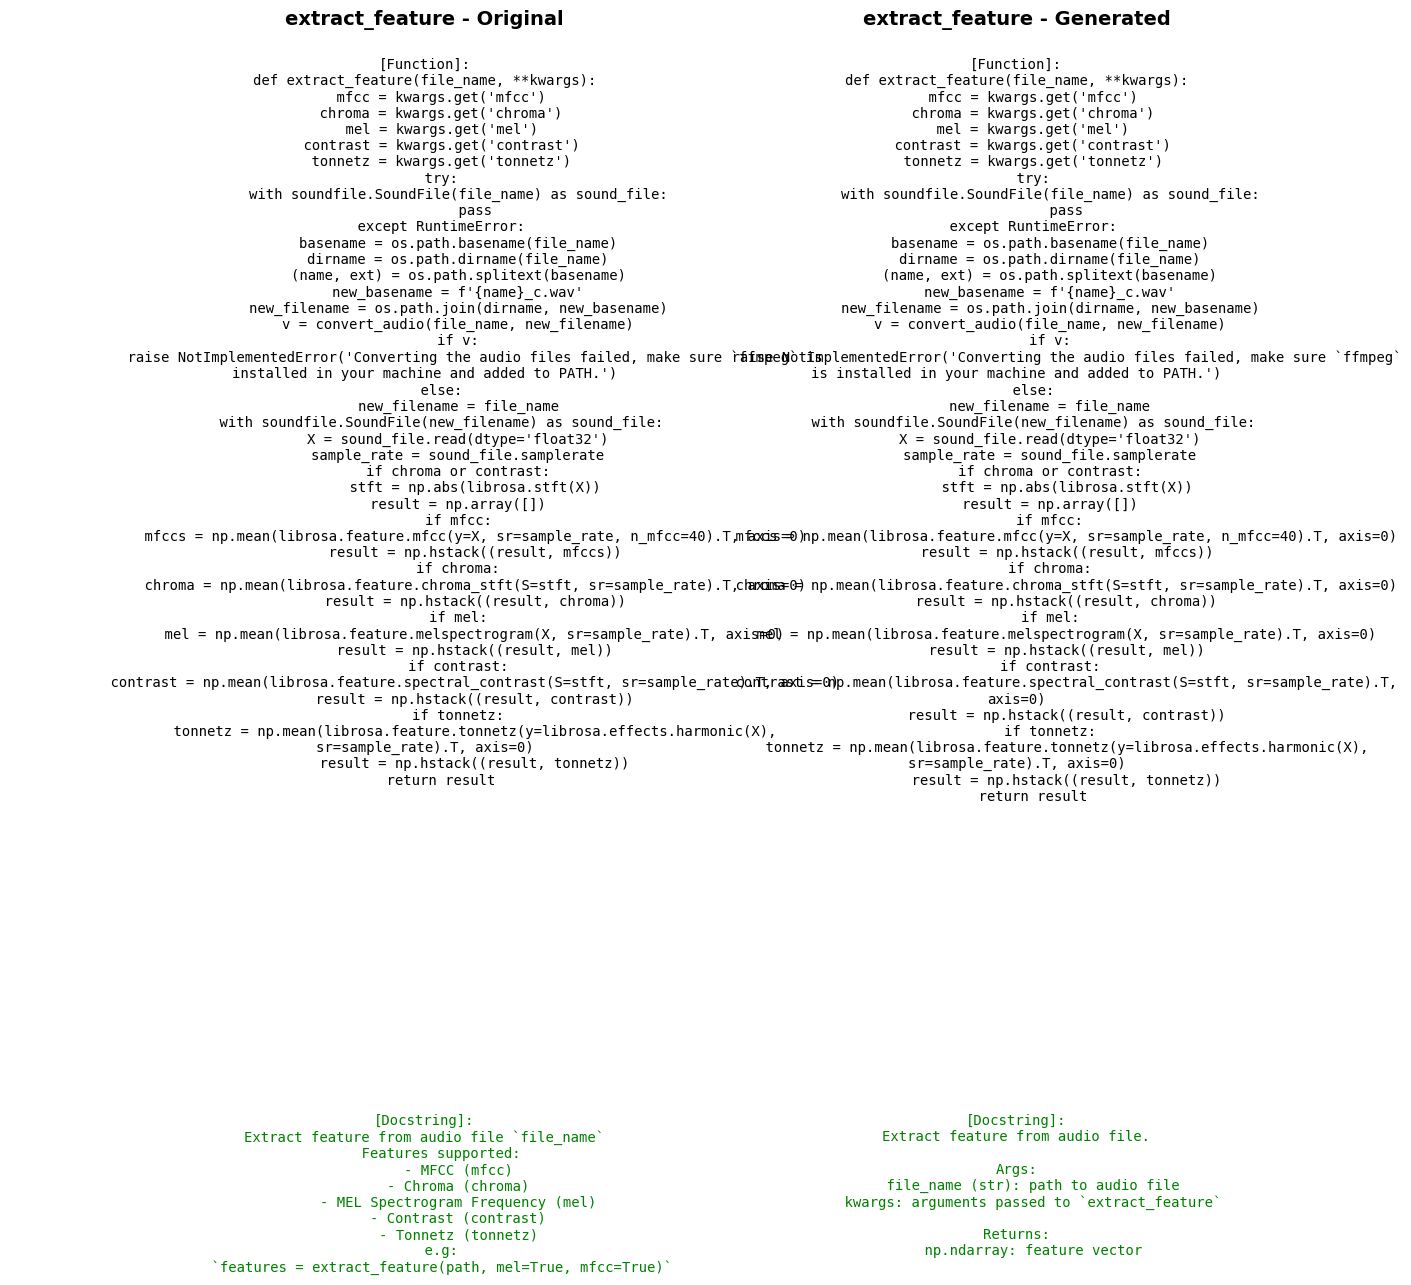

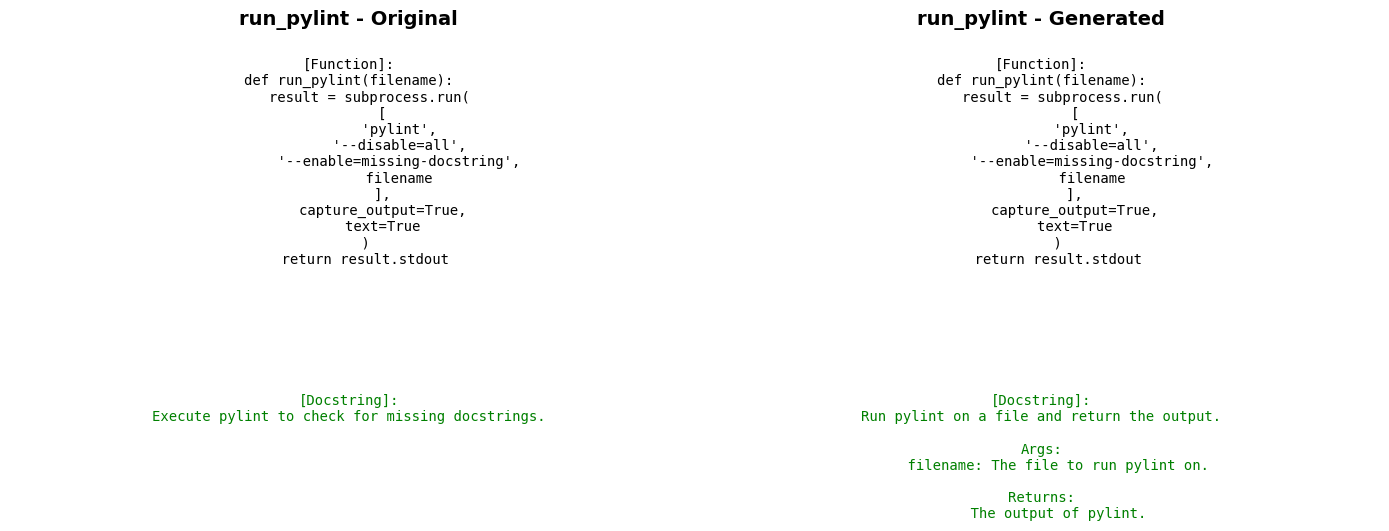

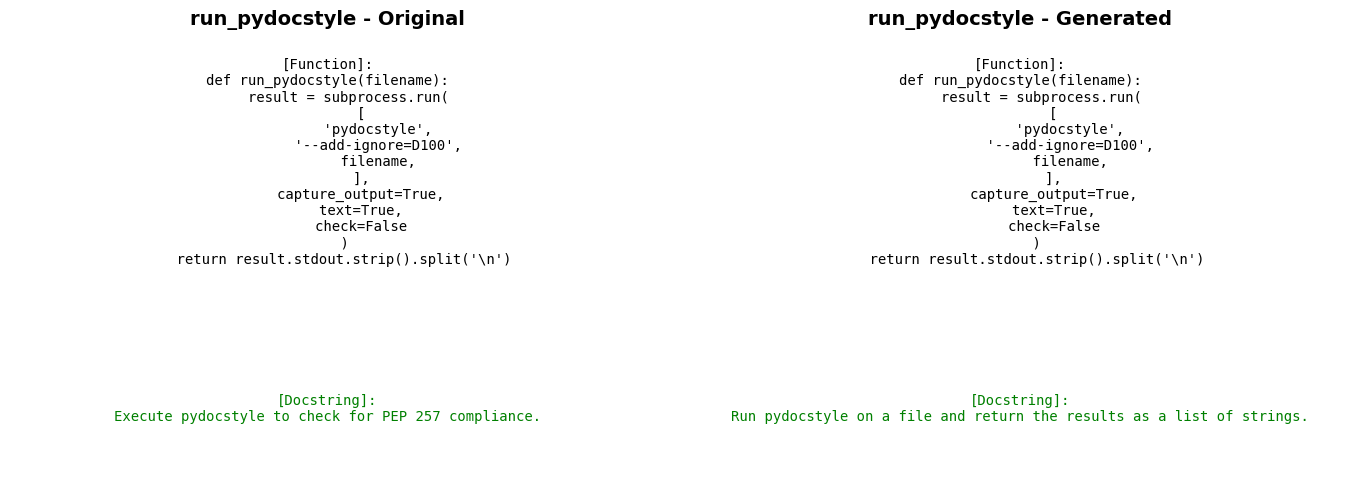

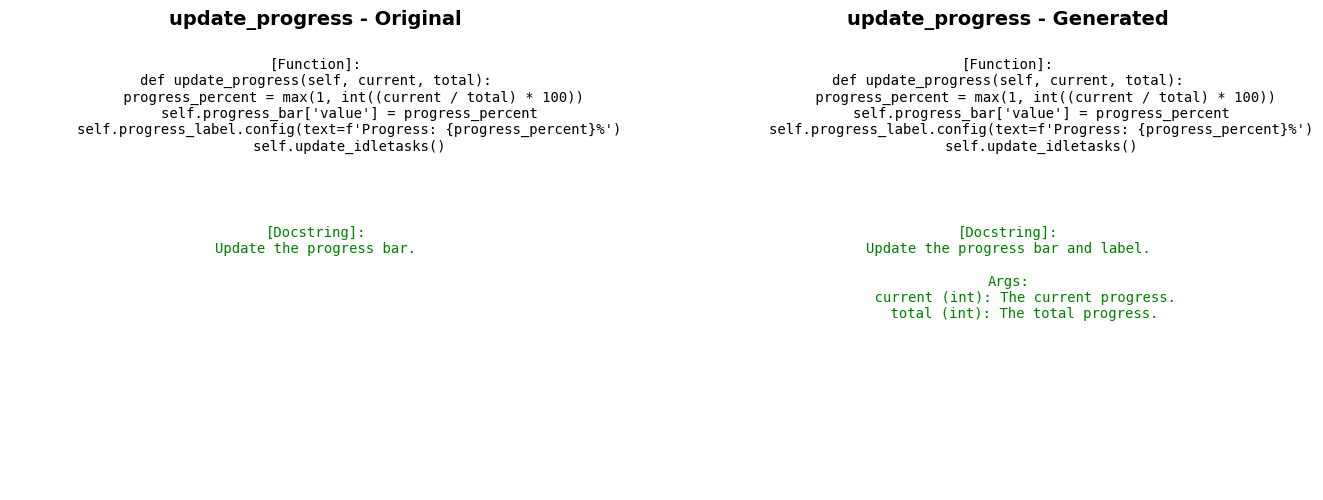

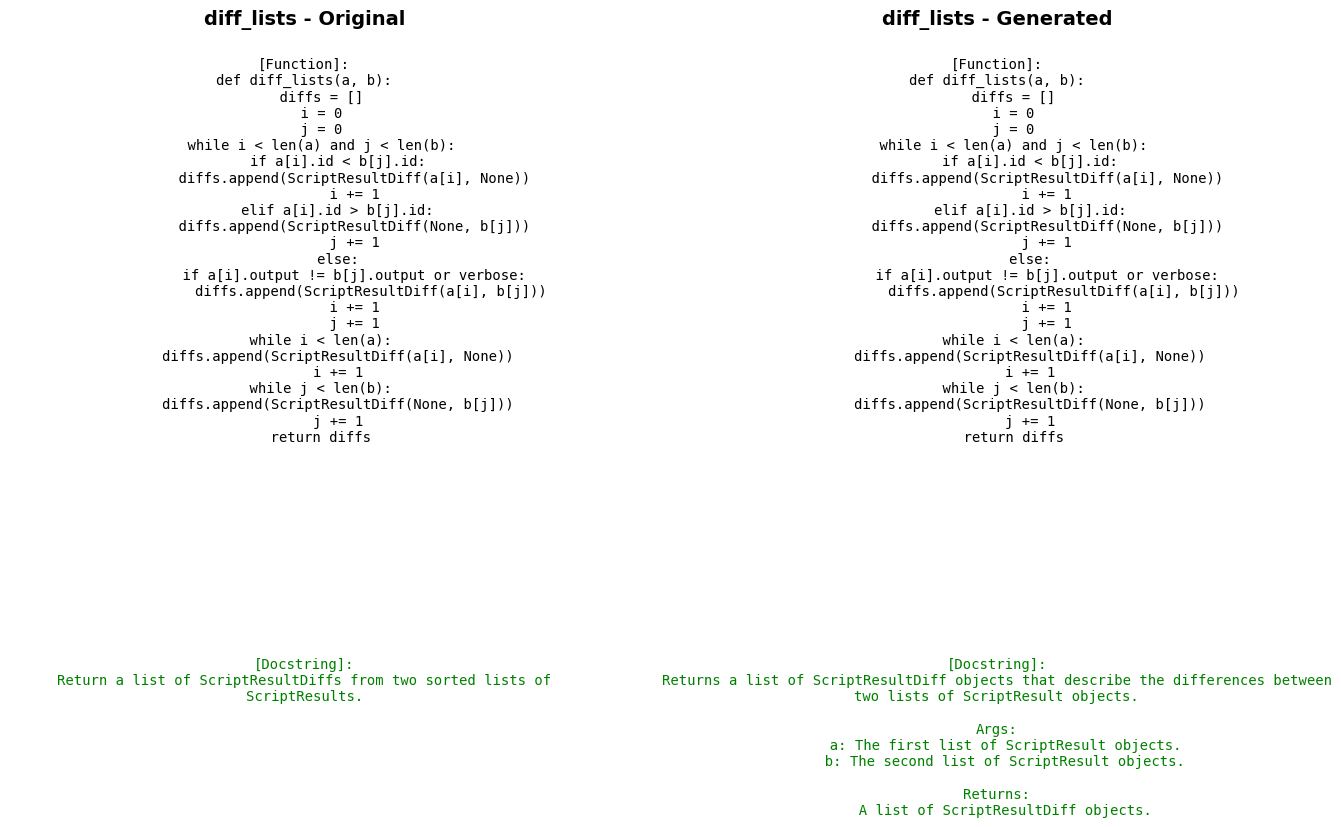

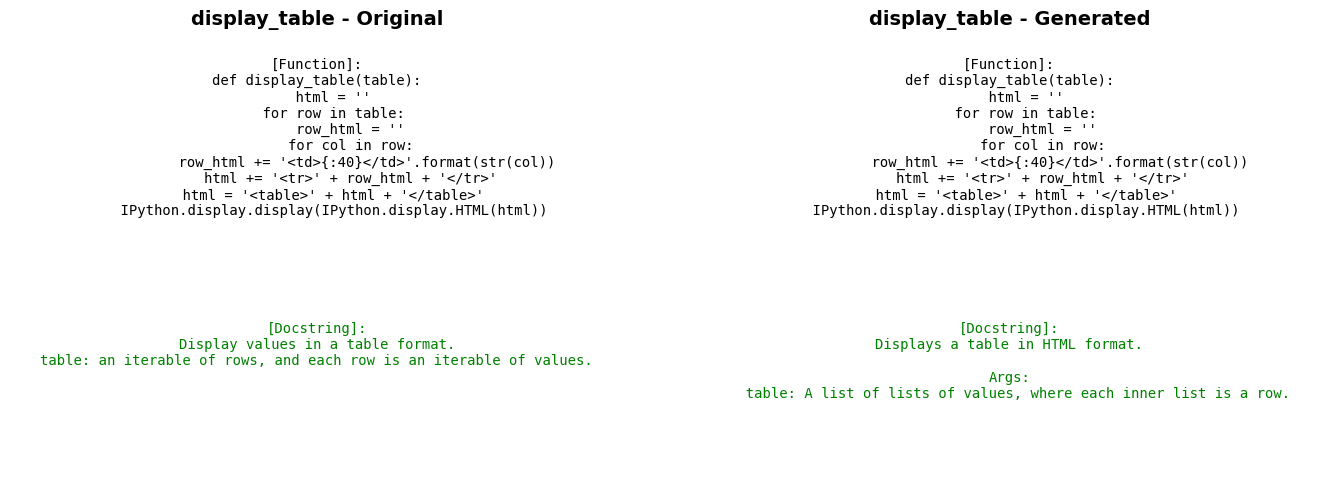

In [74]:
# Suppress warnings about the font for the display
warnings.filterwarnings("ignore", category=UserWarning, message=".*Glyph.*missing from font.*")

plot_docstring_comparison(test_data, generated_responses)

### Subjective summary
1. **`check_docstring_content`:**
 - **Syntax Adherence: 4/5**
    - The generated docstring follows the basic syntax rules.
 - **Semantic Clarity: 4/5**
    - The generated text is understandable but less concise than the reference.
 - **Completeness: 3/5**
    - The generated version omits details such as the conditions and the depth of the return, which limits the informative value.
 - **Alignment with Coding Conventions: 4/5**
    - The generated text largely matches PEP 257 and other conventions.

2. **`analyze_file`:**
 - **Syntax Adherence: 3/5**
    - The syntax is correct, but some structural elements are missing.
 - **Semantic Clarity: 4/5**
    - Meaning is conveyed, but less detailed than the reference.
 - **Completeness: 3/5**
    - The generated docstring neglects details such as the reference to the extraction of the functions.
 - **Alignment with Coding Conventions: 4/5**
     - The generated text largely matches the conventions.

3. **`_variable_on_cpu`:**
 - **Syntax Adherence: 4/5**
    - The generated docstring uses the correct syntax.
 - **Semantic Clarity: 3/5**
    - The function is fully explained, in particular to detailed.
 - **Completeness: 3/5**
    - The generated docstring contains a little too much information.
 - **Alignment with Coding Conventions: 3/5**
    - The generated text adheres to conventions.

4. **`read_fastqs`:**
 - **Syntax Adherence: 5/5**
    - The generated docstring follows the basic principles of syntax.
 - **Semantic Clarity: 5/5**
    - Clear and precise with smart terminology.
 - **Completeness: 5/5**
    - Includes all necessary details.
 - **Alignment with Coding Conventions: 4/5**
    - The generated text follows the conventions.

5. **`extract_feature`:**
 - **Syntax Adherence: 4/5**
    - The generated docstring observes the principles of syntax.
 - **Semantic Clarity: 4/5**
    - The meaning is understandable.
 - **Completeness: 3/5**
    - Lacks application examples present in the reference.
 - **Alignment with Coding Conventions: 4/5**
    - The generated text follows the conventions.


6. **`run_pylint`:**
 - **Syntax Adherence: 4/5**
    - Correct syntax, with sections for `Args` and `Returns`.
 - **Semantic Clarity: 4/5**
    - Clear description of the function.
 - **Completeness: 3/5**
    - Missing details about output value specifics.
 - **Alignment with Coding Conventions: 4/5**
    - Well-structured overall.

7. **`run_pydocstyle`:**
 - **Syntax Adherence: 4/5**
    - Syntax is correct but brief.
 - **Semantic Clarity: 4/5**
    - Describes the functionality accurately.
 - **Completeness: 3/5**
    - Omits detailed parameter and return information.
 - **Alignment with Coding Conventions: 4/5**
    - Matches conventions.

8. **`update_progress`:**
 - **Syntax Adherence: 4/5**
    - Follows standard syntax and defines arguments clearly.
 - **Semantic Clarity: 5/5**
    - Precise and clear description.
 - **Completeness: 4/5**
    - Contains all relevant information.
 - **Alignment with Coding Conventions: 5/5**
    - Fully adheres to conventions.

9. **`diff_lists`:**
 - **Syntax Adherence: 4/5**
    - The generated syntax is correct, and the sections for `args` and `returns` are present.
 - **Semantic Clarity: 4/5**
    - Clearly describes the function.
 - **Completeness: 2/5**
    - Does not specify that input lists should be sorted.
 - **Alignment with Coding Conventions: 4/5**
    - The structure of the docstring corresponds to the conventions.

10. **`display_table`:**
 - **Syntax Adherence: 5/5**
    - The generated syntax is correct and complete.
 - **Semantic Clarity: 5/5**
    - The description is clear and fully covers the functionality of the method.
 - **Completeness: 4/5**
    - Additional details about restrictions or typical inputs could be added.
 - **Alignment with Coding Conventions: 5/5**
    - The generated text fully complies with the conventions.

---
| Function                  | Syntax | Semantic | Completeness | Alignment |
|---------------------------|--------|----------|--------------|-----------|
| `check_docstring_content` | 4      | 4        | 3            | 4         |
| `analyze_file`            | 3      | 4        | 3            | 4         |
| `_variable_on_cpu`        | 4      | 3        | 3            | 3         |
| `read_fastqs`             | 5      | 5        | 5            | 4         |
| `extract_feature`         | 4      | 4        | 3            | 4         |
| `run_pylint`              | 4      | 4        | 3            | 4         |
| `run_pydocstyle`          | 4      | 4        | 3            | 4         |
| `update_progress`         | 4      | 5        | 4            | 5         |
| `diff_lists`              | 4      | 4        | 2            | 4         |
| `display_table`           | 5      | 5        | 4            | 5         |


---

The manual analysis of ten functions, evaluating syntax adherence, semantic clarity, and alignment with coding conventions, provides deeper insights into the strengths and weaknesses of the generated docstrings:

- **Syntax Adherence:**
    - **Average rating: 4.1/5**
        - The generated docstrings largely follow Python documentation standards (PEP 257). However, minor formatting details, such as properly formatted return sections, are occasionally missing.
- **Semantic Clarity:**
    - **Average rating: 4.2/5**
        - The generated docstrings usually convey the basic functionality of the method clearly. However, the language is often slightly less precise compared to the reference docstrings.
- **Completeness:**
    - **Average rating: 3.3/5**
        - The generated docstrings frequently omit key details, such as edge cases, practical examples, and detailed parameter descriptions.
- **Alignment with Coding Conventions:**
    - **Average rating: 4.1/5**
        - The structure of the generated docstrings is generally good.

Overall, the generated docstrings show a solid foundation but require improvement in detail and precision to match the quality of the references.

## Summary
The model demonstrates clear potential. While the subjective evaluation based on BLEU and ROUGE scores is relatively low, it is important to note that comparing generated texts with references is inherently challenging. Despite these limitations, the model successfully aligns basic elements of the generated docstrings with their references.

Notably, the objective evaluation reveals that the generated docstrings often adhere to established conventions. In some cases, the model produces very good results that are complete in terms of content and structure. However, challenges arise when the model needs to consider external context, such as function calls within a function.

These findings highlight that the model provides a strong foundation. With further refinements and training, it has the potential to generate even more accurate and comprehensive docstrings in the future.